In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
# matplotlib 한글 꺠짐 방지
# apt-get update
# apt-get install fonts-nanum* 
# apt-get install fontconfig
# fc-cache -fv  # font 캐시 날리기
# rm -rf /home/hy1/.cache/matplotlib/  #matplotliob 폰트 캐시 날리기


In [3]:
#!pip install matplotlib
#!pip install pandas

In [3]:
from datetime import date, datetime
from pyspark.sql.types import *
from pyspark.sql.functions import *
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt #그래프 패키지 모듈 등록
%matplotlib inline 


In [4]:
def cal_std_day(befor_day):   
    x = dt.datetime.now() - dt.timedelta(befor_day)
    year = x.year
    month = x.month if x.month >= 10 else '0'+ str(x.month)
    day = x.day if x.day >= 10 else '0'+ str(x.day)  
    return str(year)+ '-' +str(month)+ '-' +str(day)

In [5]:
import platform

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':  # 맥OS 
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':  # 윈도우
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    rc('font', family='NanumGothic')

## Transform

### 1. 지역별 단위면적(km)당 인구수와 코로나 확진자 수의 상관관계를 구해보자

In [6]:
# 면적, 인구정보
area = spark.read.csv('/corona_data/loc/sido_area.csv', encoding='CP949', header=True)
popu = spark.read.csv('/corona_data/loc/sido_population.csv', encoding='CP949', header=True)

area.show(3)
popu.show(3)

+----+----+-----+
| loc|area|ratio|
+----+----+-----+
|서울|605 |  0.6|
|부산|770 |  0.8|
|대구|883 |  0.9|
+----+----+-----+
only showing top 3 rows

+----+---------+---------+---------+
| loc|    total|     male|   female|
+----+---------+---------+---------+
|전국|52739009 |26360035 |26378974 |
|서울| 9736027 | 4721977 | 5014050 |
|부산| 3396109 | 1663619 | 1732490 |
+----+---------+---------+---------+
only showing top 3 rows




[Stage 3:>                                                          (0 + 1) / 1]



In [7]:
area_popu = area.join(popu, on='loc')
#area_popu.show()
area_popu = area_popu.select(area_popu.loc, ceil((area_popu.total/area_popu.area)).alias('popu_density'))
area_popu.show()


+----+------------+
| loc|popu_density|
+----+------------+
|서울|       16093|
|부산|        4411|
|대구|        2733|
|인천|        2831|
|광주|        2920|
|대전|        2722|
|울산|        1072|
|세종|         811|
|경기|        1366|
|강원|          93|
|충북|         221|
|충남|         265|
|전북|         226|
|전남|         152|
|경북|         141|
|경남|         321|
|제주|         378|
+----+------------+



In [10]:
# 코로나 감염자 데이터 가져오기
file_name = '/corona_data/patient/corona_patient_' + cal_std_day(2) + '.json'
tmp = spark.read.json(file_name, encoding='UTF-8')
tmp.show(3)

+--------------------+---------+------+----------+--------------+----------+
|               items|numOfRows|pageNo|resultCode|     resultMsg|totalCount|
+--------------------+---------+------+----------+--------------+----------+
|[{1465, 1461477, ...|      500|     1|        00|NORMAL SERVICE|     19684|
+--------------------+---------+------+----------+--------------+----------+




[Stage 11:>                                                         (0 + 1) / 1]



In [11]:
# 지역명과, 10만명 당 감염 현황
tmp2 = tmp.select('items').first()
co_patient = spark.createDataFrame(tmp2['items'])
#co_patient.show(3)

tmp3 = co_patient.select(co_patient.gubun.alias('loc'), co_patient.qurRate)
tmp3.show(3)
co_rate = area_popu.join(tmp3, on='loc').distinct().orderBy(col('loc'))
co_rate.show()



+----+-------+
| loc|qurRate|
+----+-------+
|경남|  44098|
|광주|  49604|
|경기|  47883|
+----+-------+
only showing top 3 rows



+----+------------+-------+
| loc|popu_density|qurRate|
+----+------------+-------+
|강원|          93|  45979|
|경기|        1366|  47883|
|경남|         321|  44098|
|경북|         141|  41475|
|광주|        2920|  49604|
|대구|        2733|  43971|
|대전|        2722|  48307|
|부산|        4411|  43180|
|서울|       16093|  49673|
|세종|         811|  50913|
|울산|        1072|  46618|
|인천|        2831|  47227|
|전남|         152|  43984|
|전북|         226|  45901|
|제주|         378|  48672|
|충남|         265|  45963|
|충북|         221|  47313|
+----+------------+-------+



<AxesSubplot:xlabel='popu_density', ylabel='qurRate'>

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


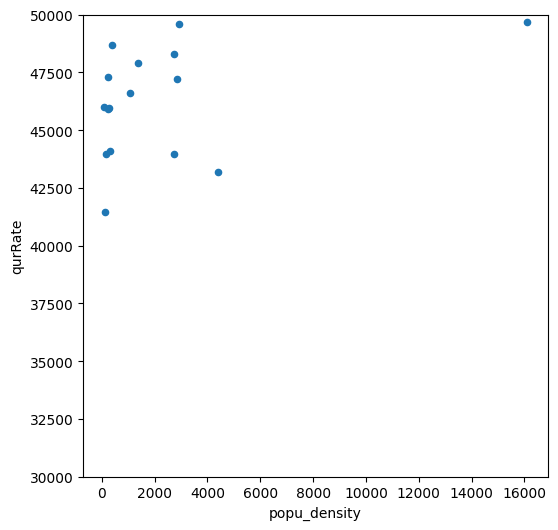

In [12]:
pd_co = co_rate.toPandas()
pd_co['qurRate'] = pd_co['qurRate'].astype(int)
pd_co.plot(kind='scatter'
           ,x='popu_density'
           ,y='qurRate'
           ,ylim=(30000,50000)
           ,figsize=(6, 6)
          )


### 2.  4차 예방접종 완료자와 코로나 확진자 수의 상관관계를 구해보자

In [18]:
file_name = '/corona_data/vaccine/corona_vaccine_' + cal_std_day(1) + '.json'
vaccine = spark.read.json(file_name)
#vaccine.show(3)
vaccine_df = spark.createDataFrame(vaccine.select('data').first()['data'])
#vaccine_df.show()

pop_vaccine = vaccine_df.join(popu, on='loc').select('loc', col('v4'), col('total'),
                                                     ceil(
                                                         (col('v4')/col('total')) * 100
                                                     ).alias('v_rate'))
pop_vaccine.show(100)




+----+-------+---------+------+
| loc|     v4|    total|v_rate|
+----+-------+---------+------+
|서울|1226070| 9736027 |    13|
|부산| 488630| 3396109 |    15|
|대구| 259429| 2412642 |    11|
|인천| 394343| 3014739 |    14|
|광주| 233610| 1462545 |    16|
|대전| 193191| 1469543 |    14|
|울산| 124886| 1138419 |    11|
|세종|  34585|  376779 |    10|
|경기|1680362|13925862 |    13|
|강원| 269222| 1555876 |    18|
|충북| 277332| 1633472 |    17|
|충남| 365655| 2181835 |    17|
|전북| 370187| 1817186 |    21|
|전남| 444061| 1865459 |    24|
|경북| 394769| 2677709 |    15|
|경남| 483703| 3377331 |    15|
|제주|  92009|  697476 |    14|
+----+-------+---------+------+



In [27]:
tmp3=co_patient.select(co_patient.gubun.alias('loc'), co_patient.qurRate)

co_vaccine_df=pop_vaccine.join(co_rate,on='loc')
co_vaccine_df=co_vaccine_df.select('loc','v_rate','qurRate').distinct()
co_vaccine_df.show(3)

+----+------+-------+
| loc|v_rate|qurRate|
+----+------+-------+
|대전|    14|  48307|
|울산|    11|  46618|
|인천|    14|  47227|
+----+------+-------+
only showing top 3 rows



<AxesSubplot:xlabel='v_rate', ylabel='qurRate'>

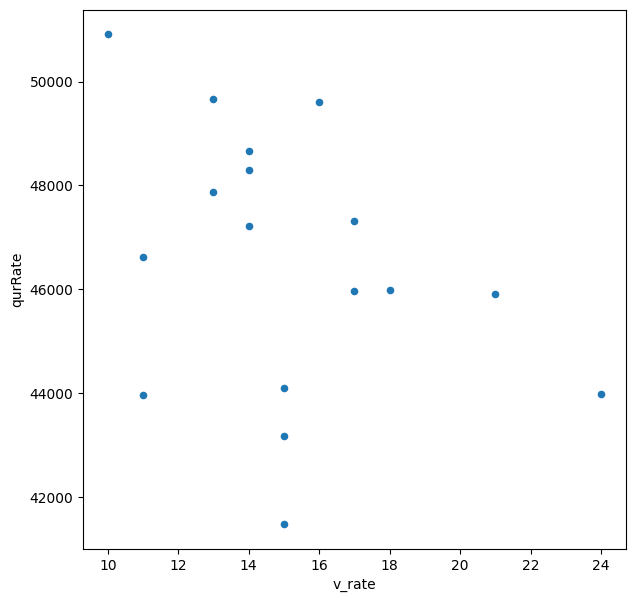

In [28]:
pd_vac = co_vaccine_df.toPandas()

pd_vac['qurRate'] = pd_vac['qurRate'].astype(int)
pd_vac.plot(kind='scatter'
           ,x='v_rate'
           ,y='qurRate'
           ,figsize=(7, 7)
          )


### 3. 다중이용시설과 코로나 확진자 수의 상관관계

In [90]:
다중이용시설 csv, 지역별 count, groupby 해서 count ,df에서 
qurRate= 10만명당 확진자수
fac_popu =10만명당 다중이용시설

In [48]:
# 면적, 인구정보
facility = spark.read.csv('/corona_data/loc/전국다중이용시설.csv', encoding='CP949', header=True)
facility.show(3)

+----+----+------+----------------+--------------+--------+
|연도|광역|시군구|          시설명|사업자등록번호|  시설군|
+----+----+------+----------------+--------------+--------+
|2020|강원|강릉시|(주)경포솔향온천|  127-86-57613|  목욕장|
|2020|강원|강릉시|  24시황실사우나|  226-33-03247|  목욕장|
|2020|강원|강릉시|    강릉고려병원|  226-82-03662|의료기관|
+----+----+------+----------------+--------------+--------+
only showing top 3 rows



In [52]:
fac_cnt=facility.groupBy(facility.광역.alias('loc')).agg(count('*').alias('fac_cnt'))
fac_cnt.show(3)

+----+-------+
| loc|fac_cnt|
+----+-------+
|경북|    944|
|대전|    767|
|전북|    759|
+----+-------+
only showing top 3 rows



In [54]:
tmp=popu.join(fac_cnt, on ='loc') #tmp=patient?
#10만명당 시설개수
fac_popu=tmp.select('loc',ceil(tmp.fac_cnt/tmp.total*100000).alias('fac_popu'))


tmp3 = co_patient.select(co_patient.gubun.alias('loc'), co_patient.qurRate)
fac_rate=fac_popu.join(tmp3,on='loc').distinct()

fac_rate.show()

+----+--------+-------+
| loc|fac_popu|qurRate|
+----+--------+-------+
|강원|      38|  45979|
|경기|      46|  47883|
|경남|      41|  44098|
|경북|      36|  41475|
|광주|      51|  49604|
|대구|      43|  43971|
|대전|      53|  48307|
|부산|      44|  43180|
|서울|      54|  49673|
|세종|      65|  50913|
|울산|      38|  46618|
|인천|      46|  47227|
|전남|      45|  43984|
|전북|      42|  45901|
|제주|      45|  48672|
|충남|      38|  45963|
|충북|      38|  47313|
+----+--------+-------+



<AxesSubplot:xlabel='fac_popu', ylabel='qurRate'>

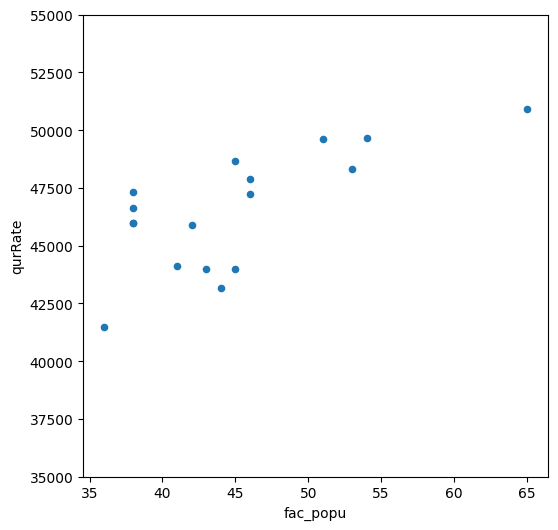

In [58]:
pd_fac = fac_rate.toPandas()
# print(pd_fac.rdd)

pd_fac['qurRate'] = pd_fac['qurRate'].astype(int)
pd_fac.plot(kind='scatter'
           ,x='fac_popu'
           ,y='qurRate'
           ,ylim=(35000,55000)
           ,figsize=(6, 6) 
          )
#결론:어느정도 기울기가 있다.

In [47]:
#내 코드
fac_df=fac.groupby(fac.광역).agg(count(fac['광역']).alias('fac_cnt'))
fac_df.show()

+----+-------+
|광역|fac_cnt|
+----+-------+
|경북|    944|
|대전|    767|
|전북|    759|
|충북|    617|
|울산|    431|
|경남|   1357|
|제주|    310|
|충남|    824|
|전남|    825|
|인천|   1386|
|부산|   1462|
|대구|   1015|
|경기|   6303|
|서울|   5224|
|광주|    732|
|세종|    243|
|강원|    584|
+----+-------+



In [45]:
# tmp3=co_patient.select(co_patient.gubun.alias('loc'), co_patient.qurRate)
tmp3['loc']=tmp3['광역']
fac_qur_df=fac_df.join(base,on='광역')
# co_vaccine_df=co_vaccine_df.select('loc','v_rate','qurRate').distinct()
fac_qur_df.show(3)

AnalysisException: Cannot resolve column name "광역" among (loc, qurRate)

MapPartitionsRDD[924] at javaToPython at <unknown>:0


+----+--------+-------+
| loc|fac_popu|qurRate|
+----+--------+-------+
|경북|      36|  34789|
|대전|      53|  41017|
|전북|      42|  38925|
|충북|      38|  40338|
|울산|      38|  40562|
|경남|      41|  37690|
|제주|      45|  42605|
|충남|      38|  39130|
|전남|      45|  36958|
|인천|      46|  41435|
|부산|      44|  37579|
|대구|      43|  36677|
|경기|      46|  41938|
|서울|      54|  44168|
|광주|      51|  42137|
|세종|      65|  43412|
|강원|      38|  39566|
+----+--------+-------+



### 4. 요일별 코로나 확진자 수를 구해보자

In [59]:
file_name ='/corona_data/patient/'
tmp=spark.read.json(file_name,encoding='UTF-8')

In [62]:
tmp.show(100)

+----------------------+---------+------+----------+--------------+----------+
|                 items|numOfRows|pageNo|resultCode|     resultMsg|totalCount|
+----------------------+---------+------+----------+--------------+----------+
|[{16, 12659, 검역, ...|      500|     1|        00|NORMAL SERVICE|     19684|
|  [{1465, 1461477, ...|      500|     1|        00|NORMAL SERVICE|     19684|
|[{16, 12440, 검역, ...|      500|     1|        00|NORMAL SERVICE|     19684|
| [{1043, 868166, 충...|      500|     1|        00|NORMAL SERVICE|     19684|
|  [{1429, 1214957, ...|      500|     1|        00|NORMAL SERVICE|     19684|
|[{528, 687990, 전남...|      500|     1|        00|NORMAL SERVICE|     19684|
|  [{25441, 20983169...|      500|     1|        00|NORMAL SERVICE|     19684|
| [{1376, 847452, 대...|      500|     1|        00|NORMAL SERVICE|     19684|
|[{520, 666170, 전남...|      500|     1|        00|NORMAL SERVICE|     19684|
|  [{5077, 4264423, ...|      500|     1|        00|NORMAL SER


[Stage 151:>                                                        (0 + 1) / 1]



In [64]:
tmp.select(tmp.items).show()

+----------------------+
|                 items|
+----------------------+
|[{16, 12659, 검역, ...|
|  [{1465, 1461477, ...|
|[{16, 12440, 검역, ...|
| [{1043, 868166, 충...|
|  [{1429, 1214957, ...|
|[{528, 687990, 전남...|
|  [{25441, 20983169...|
| [{1376, 847452, 대...|
|[{520, 666170, 전남...|
|  [{5077, 4264423, ...|
|  [{6778, 6219245, ...|
| [{1375, 842746, 대...|
|  [{2268, 1266446, ...|
| [{1475, 996824, 대...|
|  [{2249, 1204102, ...|
|[{781, 679100, 충북...|
|[{755, 648957, 대전...|
|[{883, 571175, 강원...|
|  [{1427, 1196686, ...|
| [{1492, 940948, 경...|
+----------------------+
only showing top 20 rows



In [67]:
data = []
for r1 in tmp.select(tmp.items).toLocalIterator():
    print(r1)

Row(items=[Row(deathCnt='16', defCnt='12659', gubun='검역', gubunCn='隔離區', gubunEn='Lazaretto', incDec='17', isolClearCnt='0', isolIngCnt='0', localOccCnt='0', overFlowCnt='17', qurRate='-', stdDay='2022-08-25'), Row(deathCnt='16', defCnt='12659', gubun='검역', gubunCn='隔離區', gubunEn='Lazaretto', incDec='17', isolClearCnt='0', isolIngCnt='0', localOccCnt='0', overFlowCnt='17', qurRate='-', stdDay='2022-08-25'), Row(deathCnt='6715', defCnt='6109867', gubun='경기', gubunCn='京畿', gubunEn='Gyeonggi-do', incDec='27032', isolClearCnt='0', isolIngCnt='0', localOccCnt='27007', overFlowCnt='25', qurRate='45040', stdDay='2022-08-25'), Row(deathCnt='5165', defCnt='4475520', gubun='서울', gubunCn='首尔', gubunEn='Seoul', incDec='17722', isolClearCnt='0', isolIngCnt='0', localOccCnt='17707', overFlowCnt='15', qurRate='47064', stdDay='2022-08-25'), Row(deathCnt='927', defCnt='763330', gubun='전북', gubunCn='全北', gubunEn='Jeollabuk-do', incDec='4533', isolClearCnt='0', isolIngCnt='0', localOccCnt='4482', overFlo

Row(items=[Row(deathCnt='893', defCnt='643832', gubun='전북', gubunCn='全北', gubunEn='Jeollabuk-do', incDec='2921', isolClearCnt='0', isolIngCnt='0', localOccCnt='2893', overFlowCnt='28', qurRate='36032', stdDay='2022-07-29'), Row(deathCnt='16', defCnt='11887', gubun='검역', gubunCn='隔離區', gubunEn='Lazaretto', incDec='37', isolClearCnt='0', isolIngCnt='0', localOccCnt='0', overFlowCnt='37', qurRate='-', stdDay='2022-07-29'), Row(deathCnt='1418', defCnt='1151538', gubun='인천', gubunCn='仁川', gubunEn='Incheon', incDec='4380', isolClearCnt='0', isolIngCnt='0', localOccCnt='4280', overFlowCnt='100', qurRate='39057', stdDay='2022-07-29'), Row(deathCnt='719', defCnt='552076', gubun='대전', gubunCn='大田', gubunEn='Daejeon', incDec='2557', isolClearCnt='0', isolIngCnt='0', localOccCnt='2534', overFlowCnt='23', qurRate='38015', stdDay='2022-07-29'), Row(deathCnt='1366', defCnt='816984', gubun='대구', gubunCn='大邱', gubunEn='Daegu', incDec='3498', isolClearCnt='0', isolIngCnt='0', localOccCnt='3481', overFlo

In [75]:
data = []
for r1 in tmp.select(tmp.items).toLocalIterator():
    if not r1.items: #false 만 반환
        continue
    for r2 in r1.items:
        data.append(r2)
patient_data=spark.createDataFrame(data)
patient_data.show(3)

+--------+-------+-----+-------+-----------+------+------------+----------+-----------+-----------+-------+----------+
|deathCnt| defCnt|gubun|gubunCn|    gubunEn|incDec|isolClearCnt|isolIngCnt|localOccCnt|overFlowCnt|qurRate|    stdDay|
+--------+-------+-----+-------+-----------+------+------------+----------+-----------+-----------+-------+----------+
|      16|  12659| 검역| 隔離區|  Lazaretto|    17|           0|         0|          0|         17|      -|2022-08-25|
|      16|  12659| 검역| 隔離區|  Lazaretto|    17|           0|         0|          0|         17|      -|2022-08-25|
|    6715|6109867| 경기|   京畿|Gyeonggi-do| 27032|           0|         0|      27007|         25|  45040|2022-08-25|
+--------+-------+-----+-------+-----------+------+------------+----------+-----------+-----------+-------+----------+
only showing top 3 rows



In [87]:
p=patient_data.withColumn('day_of_week', dayofweek(col('stdDay')))
p.show(3)
#localOccCnt: 당일 발생한 코로나확진자수 - 해외유입수
#요일별 수
p=p.groupBy(p.day_of_week).agg(sum(col('localOccCnt')).alias('patients')).sort(col('day_of_week'))
p.show()


+--------+-------+-----+-------+-----------+------+------------+----------+-----------+-----------+-------+----------+-----------+
|deathCnt| defCnt|gubun|gubunCn|    gubunEn|incDec|isolClearCnt|isolIngCnt|localOccCnt|overFlowCnt|qurRate|    stdDay|day_of_week|
+--------+-------+-----+-------+-----------+------+------------+----------+-----------+-----------+-------+----------+-----------+
|      16|  12659| 검역| 隔離區|  Lazaretto|    17|           0|         0|          0|         17|      -|2022-08-25|          5|
|      16|  12659| 검역| 隔離區|  Lazaretto|    17|           0|         0|          0|         17|      -|2022-08-25|          5|
|    6715|6109867| 경기|   京畿|Gyeonggi-do| 27032|           0|         0|      27007|         25|  45040|2022-08-25|          5|
+--------+-------+-----+-------+-----------+------+------------+----------+-----------+-----------+-------+----------+-----------+
only showing top 3 rows



+-----------+---------+
|day_of_week| patients|
+-----------+---------+
|          1|2371132.0|
|          2|1344660.0|
|          3|2236068.0|
|          4|3862608.0|
|          5|3843564.0|
|          6|2892264.0|
|          7|2647380.0|
+-----------+---------+



<AxesSubplot:>

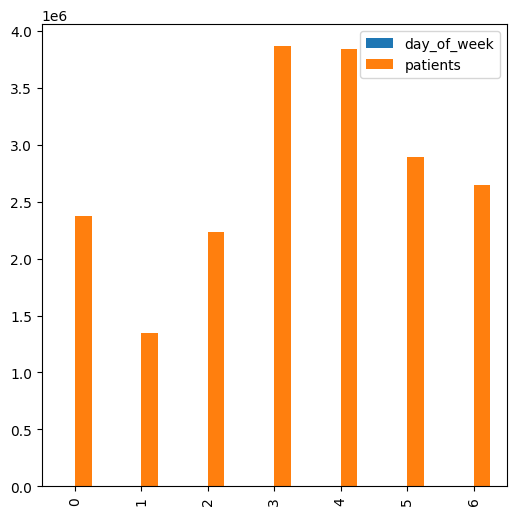

In [88]:
pd_week = p.toPandas()
pd_week.plot(kind='bar', figsize=(6, 6))



+-----------+---------+
|day_of_week| patients|
+-----------+---------+
|          1|3730348.0|
|          2|2381642.0|
|          3|5038466.0|
|          4|6983162.0|
|          5|5646140.0|
|          6|4312480.0|
|          7|4161302.0|
+-----------+---------+

